# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./256. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Fri May 26 21:04:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0               40W /  N/A|   4736MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DIY Model

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DIY_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7276
Epoch 1: val_accuracy improved from -inf to 0.66392, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 65s 155ms/step - loss: 0.6936 - accuracy: 0.7276 - val_loss: 1.2429 - val_accuracy: 0.6639 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8622
Epoch 2: val_accuracy improved from 0.66392 to 0.89295, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 65s 163ms/step - loss: 0.3779 - accuracy: 0.8622 - val_loss: 0.3443 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8988
Epoch 3: val_accuracy improved from 0.89295 to 0.92126, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 65s 162ms/step - loss: 0.2917 - accuracy: 0.8988 - val_loss: 0.2273 - val_accuracy: 0.9213 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9149
Epoch 4: val_accuracy did not improve from 0.92126
401/401 [==============================] - 60s 149ms/step - loss: 0.2422 - accuracy: 0.9149 - val_loss: 0.2912 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9355
Epoch 5: val_accuracy improved from 0.92126 to 0.94287, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 67s 166ms/step - loss: 0.1937 - accuracy: 0.9355 - val_loss: 0.1900 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9404
Epoch 6: val_accuracy improved from 0.94287 to 0.95214, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 60s 150ms/step - loss: 0.1679 - accuracy: 0.9404 - val_loss: 0.1365 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9495
Epoch 7: val_accuracy did not improve from 0.95214
401/401 [==============================] - 58s 144ms/step - loss: 0.1531 - accuracy: 0.9495 - val_loss: 0.1949 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9507
Epoch 8: val_accuracy did not improve from 0.95214
401/401 [==============================] - 57s 142ms/step - loss: 0.1458 - accuracy: 0.9507 - val_loss: 0.1606 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9523
Epoch 9: val_accuracy did not improve from 0.95214
401/401 [==============================] - 58s 144ms/step - loss: 0.1425 - accuracy: 0.9523 - val_loss: 0.2030 - va

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 64s 160ms/step - loss: 0.1368 - accuracy: 0.9503 - val_loss: 0.0940 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9552
Epoch 11: val_accuracy did not improve from 0.97530
401/401 [==============================] - 62s 155ms/step - loss: 0.1362 - accuracy: 0.9552 - val_loss: 0.1087 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9540
Epoch 12: val_accuracy did not improve from 0.97530
401/401 [==============================] - 60s 150ms/step - loss: 0.1348 - accuracy: 0.9540 - val_loss: 0.0951 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9603
Epoch 13: val_accuracy improved from 0.97530 to 0.97787, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 62s 155ms/step - loss: 0.1180 - accuracy: 0.9603 - val_loss: 0.0875 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9671
Epoch 14: val_accuracy did not improve from 0.97787
401/401 [==============================] - 58s 144ms/step - loss: 0.0930 - accuracy: 0.9671 - val_loss: 0.0841 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9679
Epoch 15: val_accuracy improved from 0.97787 to 0.98250, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 62s 154ms/step - loss: 0.0989 - accuracy: 0.9679 - val_loss: 0.0546 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9687
Epoch 16: val_accuracy did not improve from 0.98250
401/401 [==============================] - 57s 143ms/step - loss: 0.0916 - accuracy: 0.9687 - val_loss: 0.0703 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9683
Epoch 17: val_accuracy did not improve from 0.98250
401/401 [==============================] - 58s 145ms/step - loss: 0.0975 - accuracy: 0.9683 - val_loss: 0.0854 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9703
Epoch 18: val_accuracy did not improve from 0.98250
401/401 [==============================] - 57s 142ms/step - loss: 0.0938 - accuracy: 0.9703 - val_loss: 0.066

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 62s 155ms/step - loss: 0.0959 - accuracy: 0.9694 - val_loss: 0.0433 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 20/100
401/401 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9658
Epoch 20: val_accuracy did not improve from 0.98353
401/401 [==============================] - 58s 144ms/step - loss: 0.1042 - accuracy: 0.9658 - val_loss: 0.0865 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 21/100
401/401 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9687
Epoch 21: val_accuracy did not improve from 0.98353
401/401 [==============================] - 60s 148ms/step - loss: 0.0919 - accuracy: 0.9687 - val_loss: 0.0519 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 22/100
401/401 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9713
Epoch 22: val_accuracy did not improve from 0.98353
401/401 [==============================] - 57s 143ms/step - loss: 0.0745 - accuracy: 0.9713 - val_loss: 0.052

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 66s 164ms/step - loss: 0.0977 - accuracy: 0.9686 - val_loss: 0.0281 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 25/100
401/401 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9720
Epoch 25: val_accuracy improved from 0.98868 to 0.99074, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 68s 170ms/step - loss: 0.0846 - accuracy: 0.9720 - val_loss: 0.0232 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 26/100
401/401 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9753
Epoch 26: val_accuracy did not improve from 0.99074
401/401 [==============================] - 62s 155ms/step - loss: 0.0772 - accuracy: 0.9753 - val_loss: 0.0371 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 27/100
401/401 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9757
Epoch 27: val_accuracy did not improve from 0.99074
401/401 [==============================] - 60s 150ms/step - loss: 0.0775 - accuracy: 0.9757 - val_loss: 0.0227 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 28/100
401/401 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9740
Epoch 28: val_accuracy did not improve from 0.99074
401/401 [==============================] - 60s 148ms/step - loss: 0.0771 - accuracy: 0.9740 - val_loss: 0.030

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 69s 171ms/step - loss: 0.0634 - accuracy: 0.9783 - val_loss: 0.0179 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 32/100
401/401 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9779
Epoch 32: val_accuracy did not improve from 0.99331
401/401 [==============================] - 64s 159ms/step - loss: 0.0720 - accuracy: 0.9779 - val_loss: 0.1960 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 33/100
401/401 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9711
Epoch 33: val_accuracy did not improve from 0.99331
401/401 [==============================] - 63s 158ms/step - loss: 0.0877 - accuracy: 0.9711 - val_loss: 0.0293 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 34/100
401/401 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9799
Epoch 34: val_accuracy improved from 0.99331 to 0.99382, saving model to Apple_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 64s 160ms/step - loss: 0.0635 - accuracy: 0.9799 - val_loss: 0.0193 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 35/100
401/401 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9813
Epoch 35: val_accuracy did not improve from 0.99382
401/401 [==============================] - 60s 148ms/step - loss: 0.0612 - accuracy: 0.9813 - val_loss: 0.0124 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 36/100
401/401 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9763
Epoch 36: val_accuracy did not improve from 0.99382
401/401 [==============================] - 59s 147ms/step - loss: 0.0675 - accuracy: 0.9763 - val_loss: 0.0419 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 37/100
401/401 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9800
Epoch 37: val_accuracy did not improve from 0.99382
401/401 [==============================] - 61s 151ms/step - loss: 0.0645 - accuracy: 0.9800 - val_loss: 0.066

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 64s 159ms/step - loss: 0.0535 - accuracy: 0.9812 - val_loss: 0.0098 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 40/100
401/401 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9783
Epoch 40: val_accuracy did not improve from 0.99588
401/401 [==============================] - 59s 147ms/step - loss: 0.0641 - accuracy: 0.9783 - val_loss: 0.0194 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 41/100
401/401 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9832
Epoch 41: val_accuracy did not improve from 0.99588
401/401 [==============================] - 60s 151ms/step - loss: 0.0471 - accuracy: 0.9832 - val_loss: 0.0195 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 42/100
401/401 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9812
Epoch 42: val_accuracy did not improve from 0.99588
401/401 [==============================] - 59s 147ms/step - loss: 0.0575 - accuracy: 0.9812 - val_loss: 0.016

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Augmented\assets


401/401 [==============================] - 64s 161ms/step - loss: 0.0194 - accuracy: 0.9924 - val_loss: 0.0063 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 50/100
401/401 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9924
Epoch 50: val_accuracy did not improve from 0.99846
401/401 [==============================] - 61s 151ms/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.0116 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 51/100
401/401 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9938
Epoch 51: val_accuracy did not improve from 0.99846
401/401 [==============================] - 60s 151ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.0152 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 52/100
401/401 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9946
Epoch 52: val_accuracy did not improve from 0.99846
401/401 [==============================] - 59s 146ms/step - loss: 0.0147 - accuracy: 0.9946 - val

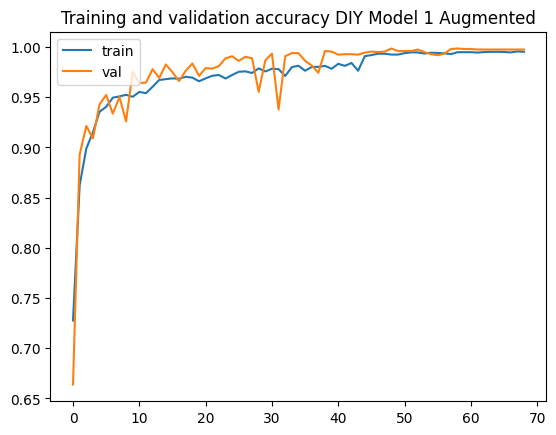

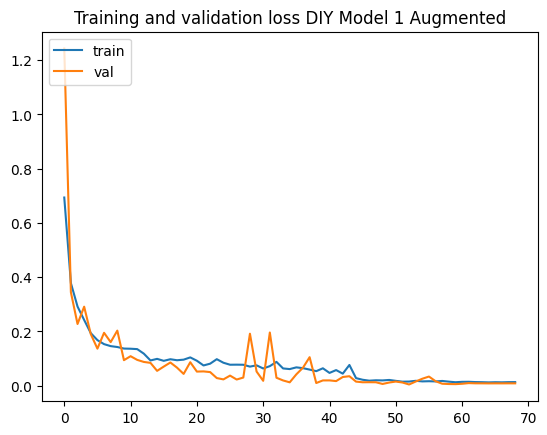

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DIY_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.7857 - accuracy: 0.6890
Epoch 1: val_accuracy improved from -inf to 0.77560, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 65s 162ms/step - loss: 0.7857 - accuracy: 0.6890 - val_loss: 0.7121 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8414
Epoch 2: val_accuracy improved from 0.77560 to 0.90685, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 68s 170ms/step - loss: 0.4399 - accuracy: 0.8414 - val_loss: 0.2757 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8906
Epoch 3: val_accuracy improved from 0.90685 to 0.91148, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 68s 170ms/step - loss: 0.3106 - accuracy: 0.8906 - val_loss: 0.2328 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9205
Epoch 4: val_accuracy improved from 0.91148 to 0.94390, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 65s 162ms/step - loss: 0.2297 - accuracy: 0.9205 - val_loss: 0.1764 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9397
Epoch 5: val_accuracy did not improve from 0.94390
401/401 [==============================] - 60s 150ms/step - loss: 0.1686 - accuracy: 0.9397 - val_loss: 0.2684 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9414
Epoch 6: val_accuracy did not improve from 0.94390
401/401 [==============================] - 62s 154ms/step - loss: 0.1692 - accuracy: 0.9414 - val_loss: 0.3205 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9503
Epoch 7: val_accuracy improved from 0.94390 to 0.96861, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 69s 173ms/step - loss: 0.1460 - accuracy: 0.9503 - val_loss: 0.1099 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9456
Epoch 8: val_accuracy did not improve from 0.96861
401/401 [==============================] - 63s 156ms/step - loss: 0.1552 - accuracy: 0.9456 - val_loss: 0.1437 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9542
Epoch 9: val_accuracy did not improve from 0.96861
401/401 [==============================] - 62s 155ms/step - loss: 0.1268 - accuracy: 0.9542 - val_loss: 0.1351 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9578
Epoch 10: val_accuracy did not improve from 0.96861
401/401 [==============================] - 59s 148ms/step - loss: 0.1238 - accuracy: 0.9578 - val_loss: 0.0913 - 

INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 66s 163ms/step - loss: 0.1153 - accuracy: 0.9619 - val_loss: 0.0587 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9651
Epoch 14: val_accuracy did not improve from 0.98096
401/401 [==============================] - 60s 149ms/step - loss: 0.0966 - accuracy: 0.9651 - val_loss: 0.2001 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9704
Epoch 15: val_accuracy did not improve from 0.98096
401/401 [==============================] - 60s 148ms/step - loss: 0.0874 - accuracy: 0.9704 - val_loss: 0.2113 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9667
Epoch 16: val_accuracy did not improve from 0.98096
401/401 [==============================] - 60s 150ms/step - loss: 0.1040 - accuracy: 0.9667 - val_loss: 0.063

INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 70s 175ms/step - loss: 0.0436 - accuracy: 0.9840 - val_loss: 0.0433 - val_accuracy: 0.9856 - lr: 1.0000e-04
Epoch 20/100
401/401 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9875
Epoch 20: val_accuracy did not improve from 0.98559
401/401 [==============================] - 61s 151ms/step - loss: 0.0332 - accuracy: 0.9875 - val_loss: 0.0356 - val_accuracy: 0.9856 - lr: 1.0000e-04
Epoch 21/100
401/401 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9893
Epoch 21: val_accuracy improved from 0.98559 to 0.98765, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 70s 175ms/step - loss: 0.0288 - accuracy: 0.9893 - val_loss: 0.0347 - val_accuracy: 0.9876 - lr: 1.0000e-04
Epoch 22/100
401/401 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9903
Epoch 22: val_accuracy did not improve from 0.98765
401/401 [==============================] - 60s 149ms/step - loss: 0.0256 - accuracy: 0.9903 - val_loss: 0.0470 - val_accuracy: 0.9856 - lr: 1.0000e-04
Epoch 23/100
401/401 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9891
Epoch 23: val_accuracy improved from 0.98765 to 0.99022, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 71s 176ms/step - loss: 0.0288 - accuracy: 0.9891 - val_loss: 0.0283 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 24/100
401/401 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9889
Epoch 24: val_accuracy did not improve from 0.99022
401/401 [==============================] - 60s 149ms/step - loss: 0.0274 - accuracy: 0.9889 - val_loss: 0.0311 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 25/100
401/401 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9889
Epoch 25: val_accuracy did not improve from 0.99022
401/401 [==============================] - 61s 151ms/step - loss: 0.0270 - accuracy: 0.9889 - val_loss: 0.0350 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 26/100
401/401 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9911
Epoch 26: val_accuracy improved from 0.99022 to 0.99074, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 67s 167ms/step - loss: 0.0236 - accuracy: 0.9911 - val_loss: 0.0210 - val_accuracy: 0.9907 - lr: 1.0000e-04
Epoch 27/100
401/401 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9903
Epoch 27: val_accuracy did not improve from 0.99074
401/401 [==============================] - 60s 149ms/step - loss: 0.0215 - accuracy: 0.9903 - val_loss: 0.0242 - val_accuracy: 0.9897 - lr: 1.0000e-04
Epoch 28/100
401/401 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9919
Epoch 28: val_accuracy improved from 0.99074 to 0.99382, saving model to Apple_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Augmented\assets


401/401 [==============================] - 69s 172ms/step - loss: 0.0223 - accuracy: 0.9919 - val_loss: 0.0222 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 29/100
401/401 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9920
Epoch 29: val_accuracy did not improve from 0.99382
401/401 [==============================] - 61s 152ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0295 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 30/100
401/401 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9921
Epoch 30: val_accuracy did not improve from 0.99382
401/401 [==============================] - 61s 151ms/step - loss: 0.0191 - accuracy: 0.9921 - val_loss: 0.0324 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 31/100
401/401 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9914
Epoch 31: val_accuracy did not improve from 0.99382

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
401/401 [=========

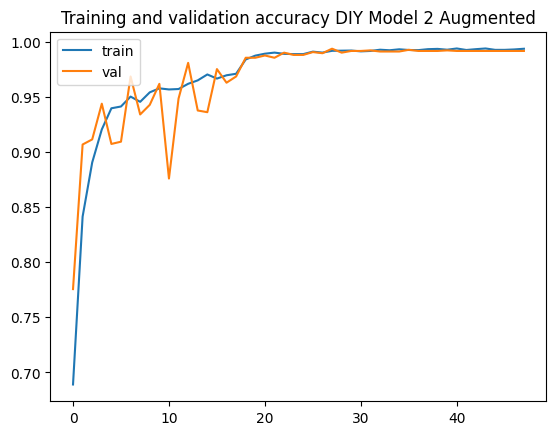

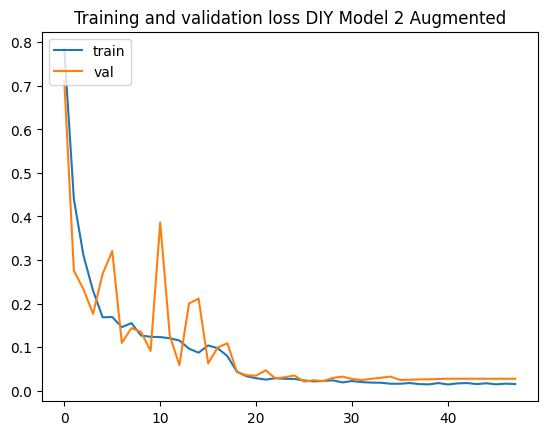

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')